## Import Libraries

In [1]:
import os
os.chdir("/home/sermengi/verifywise_dev/verifywise/BiasAndFairnessModule")

from src.core.config import ConfigManager
from src.dataset_loader.data_loader import DataLoader
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.cm as cm

from fairlearn.metrics import MetricFrame, demographic_parity_difference, selection_rate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from src.eval_engine.metrics import equalized_odds, conditional_statistical_parity
from sklearn.metrics import accuracy_score
from sklearn.calibration import calibration_curve

import seaborn as sns

/home/sermengi/verifywise_dev/verifywise/BiasAndFairnessModule/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create Synthetic Data

In [2]:
config_manager = ConfigManager()
dataset_config = config_manager.get_dataset_config()
data_loader = DataLoader(dataset_config)
df = data_loader.load_data()
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,Unknown,77053,HS-grad,9,Widowed,Unknown,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,Unknown,186061,Some-college,10,Widowed,Unknown,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [3]:
df_subsampled = df.sample(n=500, random_state=42).reset_index(drop=True)
df_subsampled

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,29,Private,280618,Some-college,10,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States,<=50K
1,19,Private,439779,Some-college,10,Never-married,Sales,Own-child,White,Male,0,0,15,United-States,<=50K
2,28,Private,204734,Some-college,10,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,40,United-States,<=50K
3,35,Private,107991,11th,7,Never-married,Sales,Not-in-family,White,Male,0,0,45,United-States,<=50K
4,20,Private,54152,Some-college,10,Never-married,Adm-clerical,Own-child,White,Female,0,0,30,Unknown,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,59,Private,189721,Bachelors,13,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,Italy,>50K
496,39,Private,388023,HS-grad,9,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,38,United-States,<=50K
497,25,Private,27411,Bachelors,13,Divorced,Sales,Not-in-family,White,Female,0,0,40,United-States,<=50K
498,18,Unknown,192399,Some-college,10,Never-married,Unknown,Own-child,White,Male,0,0,60,United-States,<=50K


In [4]:
df_subsampled.income.value_counts(normalize=True)

income
<=50K    0.766
>50K     0.234
Name: proportion, dtype: float64

In [5]:
y_pred = np.random.choice(df_subsampled["income"].unique().tolist(), size=len(df_subsampled), p=[0.9, 0.1])
df_subsampled["prediction"] = y_pred
df_subsampled["prediction"].value_counts(normalize=True)

prediction
<=50K    0.902
>50K     0.098
Name: proportion, dtype: float64

In [6]:
df_subsampled.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income', 'prediction'],
      dtype='object')

In [7]:
protected_attributes = ["sex", "race", "occupation", "education"]
required_columns = protected_attributes + ["income", "prediction"]

df_results = df_subsampled[required_columns]
df_results.head()

,sex,race,occupation,education,income,prediction
0,Male,White,Handlers-cleaners,Some-college,<=50K,<=50K
1,Male,White,Sales,Some-college,<=50K,<=50K
2,Female,White,Tech-support,Some-college,<=50K,>50K
3,Male,White,Sales,11th,<=50K,<=50K
4,Female,White,Adm-clerical,Some-college,<=50K,>50K


In [8]:
categorical_unique_values = {col: df_results[col].unique() for col in df_results.drop(columns=["prediction"]).select_dtypes("O")}
encoding_dict = {col: {val: i for i, val in enumerate(values)} for col, values in categorical_unique_values.items()}
encoding_dict.update({"prediction": encoding_dict["income"]})
df_encoded = df_results.copy()

for col in df_encoded.select_dtypes("O").columns:
    df_encoded[col] = df_encoded[col].map(encoding_dict[col])

np.random.seed(42)
df_encoded["scores"] =np.random.random(len(df_encoded))

df_encoded

,sex,race,occupation,education,income,prediction,scores
0,0,0,0,0,0,0,0.374540
1,0,0,1,0,0,0,0.950714
2,1,0,2,0,0,1,0.731994
3,0,0,1,1,0,0,0.598658
4,1,0,3,0,0,1,0.156019
...,...,...,...,...,...,...,...
495,0,0,0,2,1,0,0.353352
496,1,0,8,5,0,1,0.583656
497,1,0,1,2,0,0,0.077735
498,0,0,7,0,0,1,0.974395


## Create Visualization

* **Protected Group Distributions**

In [9]:
def plot_protected_group_distribution(series: pd.Series, reverse_dict: dict, title: str = "Group Distribution"):
    """
    Plot a pie chart of the distribution of protected groups.

    Parameters
    ----------
    series : pd.Series
        Encoded protected attribute values (e.g., 0, 1, 2).
    reverse_dict : dict
        Dictionary mapping encoded values back to original labels (e.g., {0: 'Male', 1: 'Female'}).
    title : str, optional
        Title of the plot (default is "Group Distribution").
    """

    # Map encoded values back to original labels
    decoded_series = series.map(reverse_dict)

    # Count frequencies
    group_counts = decoded_series.value_counts()

    # Plot pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(
        group_counts,
        labels=group_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        counterclock=False,
    )
    plt.title(title)
    plt.show()

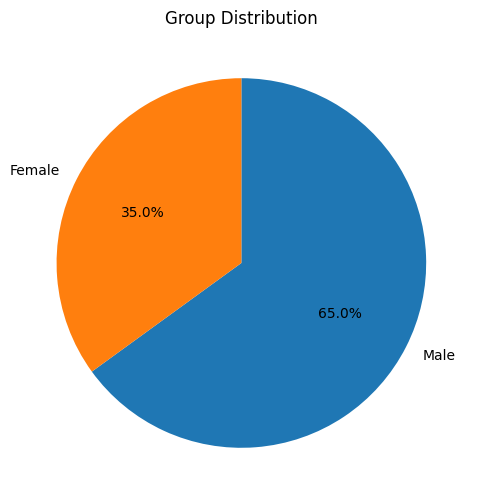

In [10]:
plot_protected_group_distribution(df_encoded["sex"], {v: k for k, v in encoding_dict["sex"].items()})

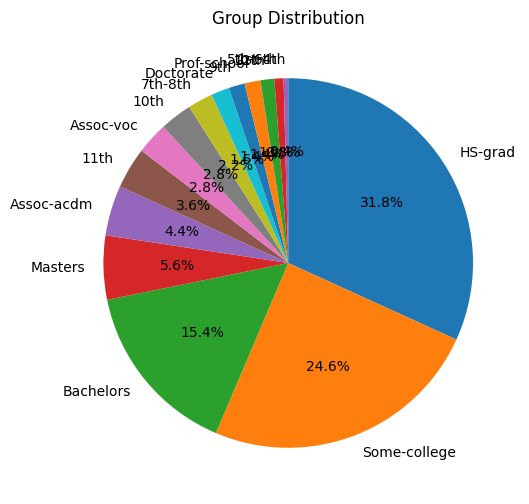

In [11]:
plot_protected_group_distribution(df_encoded["education"], {v: k for k, v in encoding_dict["education"].items()})

* **Selection Rate and Demographic Parity**

In [ ]:
dpd = MetricFrame(
    metrics = selection_rate, 
    y_true = df_encoded["income"],
    y_pred = df_encoded["prediction"],
    sensitive_features = df_encoded["occupation"])

In [13]:
group_rates = dpd.by_group
overall_rate = dpd.overall
dpd = dpd.difference()

print("Selection rate by group:\n", group_rates)
print("Overall selection rate:", overall_rate)
print("Demographic Parity Difference:", dpd)

Selection rate by group:
 occupation
0     0.000000
1     0.016949
2     0.157895
3     0.173077
4     0.078431
5     0.115385
6     0.111111
7     0.093750
8     0.101449
9     0.131148
10    0.153846
11    0.074074
12    0.000000
13    0.000000
Name: selection_rate, dtype: float64
Overall selection rate: 0.098
Demographic Parity Difference: 0.17307692307692307


In [14]:
def plot_demographic_parity(y_true, y_pred, sensitive_features, attribute_name="Group"):
    """
    Plot Demographic Parity (selection rates) by sensitive attribute groups.
    
    Each group is shown with a distinct color.
    """
    # Compute selection rates by group
    mf = MetricFrame(
        metrics=selection_rate,
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sensitive_features
    )

    group_rates = mf.by_group
    overall_rate = mf.overall
    dpd = mf.difference()

    print(f"Selection rate by {attribute_name}:\n", group_rates)
    print(f"Overall selection rate: {overall_rate:.3f}")
    print(f"Demographic Parity Difference: {dpd:.3f}")

    # --- Visualization ---
    fig, ax = plt.subplots(figsize=(7, 5))

    # Use the new colormap API
    num_groups = len(group_rates)
    cmap = plt.colormaps["tab10"]  # or "tab20" if you have many groups
    colors = [cmap(i % cmap.N) for i in range(num_groups)]

    # Bar plot with different colors for each group
    group_rates.plot(
        kind="bar",
        ax=ax,
        color=colors,
        edgecolor="black"
    )

    # Add horizontal line for overall selection rate
    ax.axhline(y=overall_rate, color="green", linestyle="--", linewidth=1.5, label="Overall Rate")

    # Title & labels
    ax.set_title(f"Demographic Parity by {attribute_name}", fontsize=14)
    ax.set_ylabel("Selection Rate (P(Ŷ=1))", fontsize=12)
    ax.set_xlabel(attribute_name, fontsize=12)
    ax.legend()

    # Annotate DP difference
    ax.text(
        0.5,
        max(group_rates) + 0.02,
        f"DP Difference = {dpd:.3f}",
        ha="center", fontsize=12, color="red"
    )

    plt.tight_layout()
    plt.show()

Selection rate by Group:
 occupation
0     0.000000
1     0.016949
2     0.157895
3     0.173077
4     0.078431
5     0.115385
6     0.111111
7     0.093750
8     0.101449
9     0.131148
10    0.153846
11    0.074074
12    0.000000
13    0.000000
Name: selection_rate, dtype: float64
Overall selection rate: 0.098
Demographic Parity Difference: 0.173


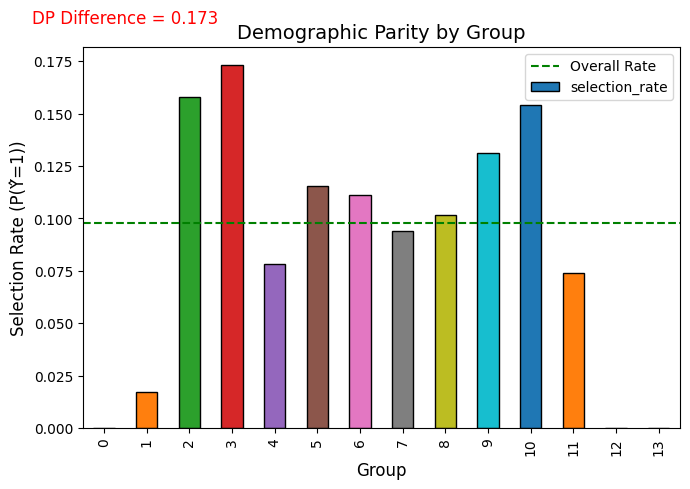

In [30]:
plot_demographic_parity(y_true=df_encoded["income"], y_pred=df_encoded["prediction"], sensitive_features=df_encoded["occupation"])

* **Groupwise Confusion Matrix**

In [ ]:
def plot_groupwise_confusion_matrices(y_true, y_pred, sensitive_attr, sensitive_mapping, labels=None, normalize=None):
    """
    Plot confusion matrices for each subgroup defined by the sensitive attribute.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        Ground truth labels.
    y_pred : array-like of shape (n_samples,)
        Predicted labels.
    sensitive_attr : array-like of shape (n_samples,)
        Encoded sensitive attribute values (e.g., 0, 1).
    sensitive_mapping : dict
        Mapping from encoded sensitive attribute values to human-readable labels.
        Example: {0: "Male", 1: "Female"}
    labels : list, optional
        The list of class labels. If None, inferred from y_true.
    normalize : {'true', 'pred', 'all'}, default=None
        Normalization mode for confusion matrix.
    """
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    sensitive_attr = np.array(sensitive_attr)

    unique_groups = np.unique(sensitive_attr)
    n_groups = len(unique_groups)

    fig, axes = plt.subplots(1, n_groups, figsize=(5 * n_groups, 4))

    if n_groups == 1:  # handle case of only one group
        axes = [axes]

    for ax, group in zip(axes, unique_groups):
        mask = sensitive_attr == group
        cm = confusion_matrix(y_true[mask], y_pred[mask], labels=labels, normalize=normalize)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot(ax=ax, colorbar=False, cmap="Blues")
        
        group_name = sensitive_mapping.get(group, f"Group {group}")
        ax.set_title(f"Group: {group_name}")

    plt.tight_layout()
    plt.show()

def plot_groupwise_confusion_matrices(y_true, y_pred, sensitive_attr, sensitive_mapping, labels=None, normalize=None):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    sensitive_attr = np.array(sensitive_attr)

    unique_groups = np.unique(sensitive_attr)
    n_groups = len(unique_groups)

    fig, axes = plt.subplots(1, n_groups, figsize=(5 * n_groups, 4))

    if n_groups == 1:  # handle case of only one group
        axes = [axes]

    for ax, group in zip(axes, unique_groups):
        mask = sensitive_attr == group
        cm = confusion_matrix(y_true[mask], y_pred[mask], labels=labels, normalize=normalize)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot(ax=ax, colorbar=False, cmap="Blues")

        group_name = sensitive_mapping.get(group, f"Group {group}")
        ax.set_title(f"Group: {group_name}")

    plt.tight_layout()
    plt.show()


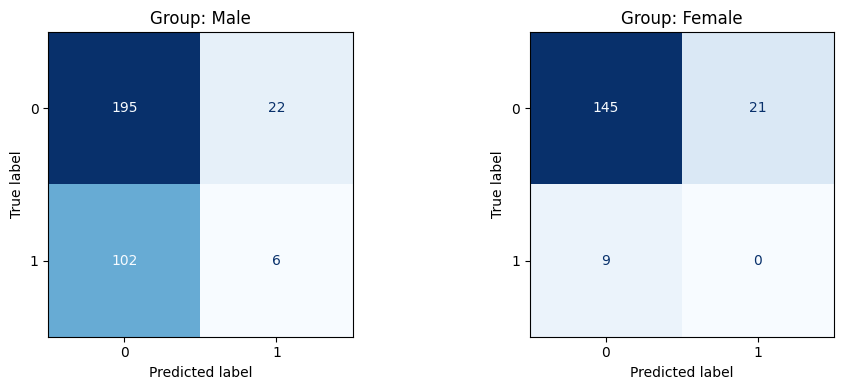

In [17]:
plot_groupwise_confusion_matrices(
    y_true=df_encoded["income"],
    y_pred=df_encoded["prediction"],
    sensitive_attr=df_encoded["sex"],
    sensitive_mapping={v: k for k, v in encoding_dict["sex"].items()}
)

* **Equalized Odds vs overall accuracy**

In [ ]:
def create_fairness_vs_accuracy_plot(y_true, y_pred, y_scores, sensitive_attr):
    # loop across thresholds
    results = []
    for thresh in np.linspace(0, 1, 21):
        y_pred_bin = (y_scores >= thresh).astype(int)
        acc = accuracy_score(y_true, y_pred_bin)
        eo = equalized_odds(y_true, y_pred, sensitive_attr)
        results.append({"threshold": thresh, "accuracy": acc, "eo_diff": eo})
    
    eod_df = pd.DataFrame(results)

    plt.figure(figsize=(8,6))
    plt.scatter(eod_df["accuracy"], eod_df["eo_diff"], c=eod_df["threshold"], cmap="viridis", s=80)
    plt.colorbar(label="Threshold")
    plt.xlabel("Accuracy")
    plt.ylabel("Equalized Odds Difference")
    plt.title("Fairness vs Accuracy Trade-off")
    plt.show()

def create_fairness_vs_accuracy_plot(y_true, y_pred, y_scores, sensitive_attr):
    # loop across thresholds
    results = []
    for thresh in np.linspace(0, 1, 21):
        y_pred_bin = (y_scores >= thresh).astype(int)
        acc = accuracy_score(y_true, y_pred_bin)
        eo = equalized_odds(y_true, y_pred, sensitive_attr)
        results.append({"threshold": thresh, "accuracy": acc, "eo_diff": eo})

    eod_df = pd.DataFrame(results)

    plt.figure(figsize=(8,6))
    plt.scatter(eod_df["accuracy"], eod_df["eo_diff"], c=eod_df["threshold"], cmap="viridis", s=80)
    plt.colorbar(label="Threshold")
    plt.xlabel("Accuracy")
    plt.ylabel("Equalized Odds Difference")
    plt.title("Fairness vs Accuracy Trade-off")
    plt.show()


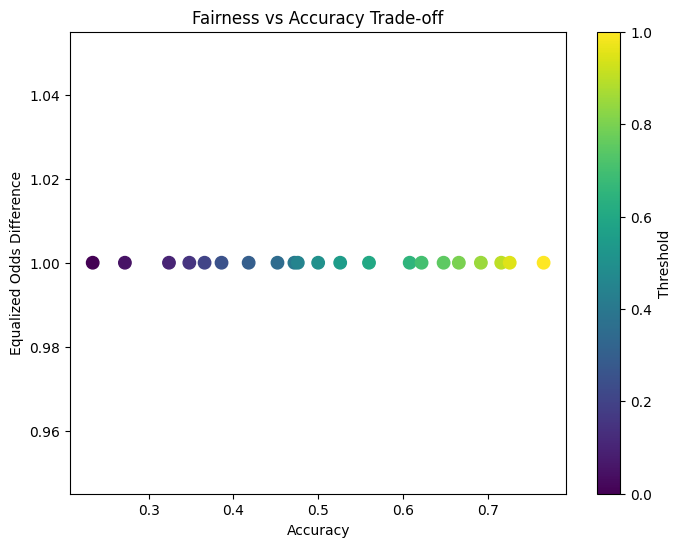

In [19]:
create_fairness_vs_accuracy_plot(df_encoded["income"], df_encoded["prediction"], df_encoded["scores"], df_encoded["education"])

* **Calibration Curves**

In [ ]:
def plot_calibration_by_group(y_true, y_prob, protected_attr, n_bins=10):
    groups = np.unique(protected_attr)
    
    plt.figure(figsize=(8, 6))
    
    for group in groups:
        mask = (protected_attr == group)
        prob_true, prob_pred = calibration_curve(
            y_true[mask], y_prob[mask], n_bins=n_bins, strategy='uniform'
        )
        plt.plot(prob_pred, prob_true, marker='o', label=f"{group}")
    
    # Reference line (perfect calibration)
    plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
    
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title("Calibration Plot by Subgroup")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

def plot_calibration_by_group(y_true, y_prob, protected_attr, n_bins=10):
    groups = np.unique(protected_attr)

    plt.figure(figsize=(8, 6))

    for group in groups:
        mask = (protected_attr == group)
        prob_true, prob_pred = calibration_curve(
            y_true[mask], y_prob[mask], n_bins=n_bins, strategy='uniform'
        )
        plt.plot(prob_pred, prob_true, marker='o', label=f"{group}")

    # Reference line (perfect calibration)
    plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")

    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title("Calibration Plot by Subgroup")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()


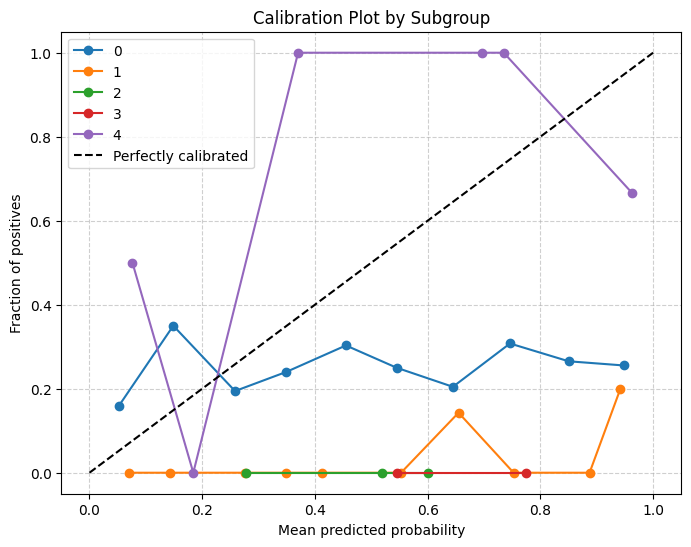

In [21]:
plot_calibration_by_group(df_encoded["income"], df_encoded["scores"], df_encoded["race"])

* **Group Metrics Box Plots**

In [ ]:
def compute_group_metrics(y_true, y_pred, sensitive_attr):
    metrics = []

    for group in np.unique(sensitive_attr):
        idx = sensitive_attr == group
        y_true_g = y_true[idx]
        y_pred_g = y_pred[idx]

        tn, fp, fn, tp = confusion_matrix(y_true_g, y_pred_g, labels=[0, 1]).ravel()

        # Safe division with epsilon
        eps = 1e-10
        tpr = tp / (tp + fn + eps)   # Sensitivity, Recall
        fpr = fp / (fp + tn + eps)
        ppv = tp / (tp + fp + eps)   # Precision
        npv = tn / (tn + fn + eps)

        metrics.append({
            "group": group,
            "TPR": tpr,
            "FPR": fpr,
            "PPV": ppv,
            "NPV": npv
        })

    return pd.DataFrame(metrics)

def compute_group_metrics(y_true, y_pred, sensitive_attr):
    metrics = []

    for group in np.unique(sensitive_attr):
        idx = sensitive_attr == group
        y_true_g = y_true[idx]
        y_pred_g = y_pred[idx]

        tn, fp, fn, tp = confusion_matrix(y_true_g, y_pred_g, labels=[0, 1]).ravel()

        # Safe division with epsilon
        eps = 1e-10
        tpr = tp / (tp + fn + eps)   # Sensitivity, Recall
        fpr = fp / (fp + tn + eps)
        ppv = tp / (tp + fp + eps)   # Precision
        npv = tn / (tn + fn + eps)

        metrics.append({
            "group": group,
            "TPR": tpr,
            "FPR": fpr,
            "PPV": ppv,
            "NPV": npv
        })

    return pd.DataFrame(metrics)


In [ ]:
def plot_group_metrics_boxplots(y_true, y_pred, sensitive_attr):
    """
    Creates side-by-side box plots for TPR, FPR, PPV, and NPV across groups.
    """
    df_metrics = compute_group_metrics(y_true, y_pred, sensitive_attr)

    # Melt into long format
    df_melted = df_metrics.melt(id_vars="group", var_name="Metric", value_name="Value")

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_melted, x="Metric", y="Value")

    plt.title("Fairness Metrics Across Groups")
    plt.xlabel("Metric")
    plt.ylabel("Value")
    plt.ylim(0, 1)
    plt.legend(title="Group")
    plt.show()

def plot_group_metrics_boxplots(y_true, y_pred, sensitive_attr):
    df_metrics = compute_group_metrics(y_true, y_pred, sensitive_attr)

    # Melt into long format
    df_melted = df_metrics.melt(id_vars="group", var_name="Metric", value_name="Value")

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_melted, x="Metric", y="Value")

    plt.title("Fairness Metrics Across Groups")
    plt.xlabel("Metric")
    plt.ylabel("Value")
    plt.ylim(0, 1)
    plt.legend(title="Group")
    plt.show()


/tmp/ipykernel_4041/3246868768.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Group")


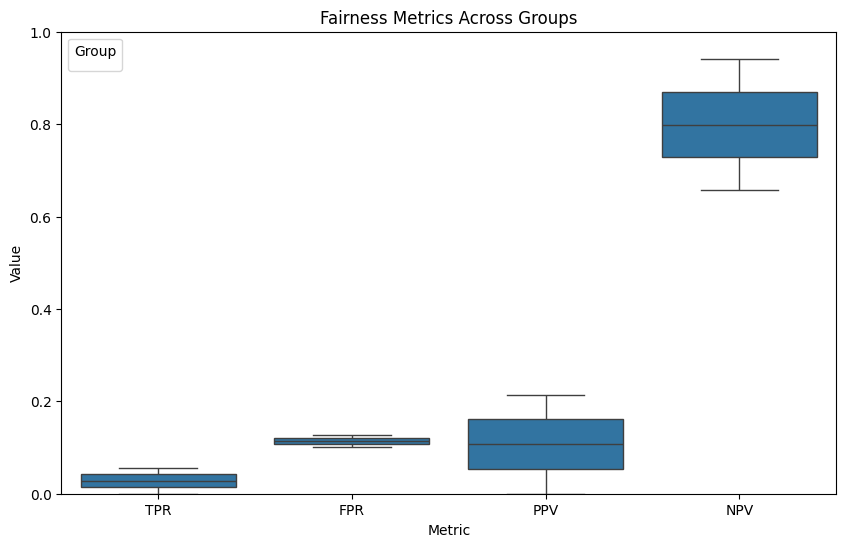

In [24]:
plot_group_metrics_boxplots(df_encoded["income"], df_encoded["prediction"], df_encoded["sex"])

* **Radar Chart For Metric Comparisons**

In [ ]:
def plot_fairness_radar(metrics_dict, title="Fairness Metrics Radar Chart"):
    """
    Plots a radar chart for fairness metrics.
    
    Args:
        metrics_dict (dict): Keys are group names, values are dicts of metric_name: metric_value
                             Example:
                             {
                                 "Male": {"Demographic Parity": 0.9, "Equalized Odds": 0.85, ...},
                                 "Female": {"Demographic Parity": 0.7, "Equalized Odds": 0.65, ...}
                             }
        title (str): Chart title
    """
    groups = list(metrics_dict.keys())
    metric_names = list(next(iter(metrics_dict.values())).keys())
    N = len(metric_names)
    
    # Compute angles for radar axes
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # complete the loop

    # Initialize the radar chart
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

    for group in groups:
        values = list(metrics_dict[group].values())
        values += values[:1]  # complete the loop
        ax.plot(angles, values, label=group, linewidth=2)
        ax.fill(angles, values, alpha=0.25)
    
    # Set metric labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_names)
    
    # Optional: set range 0-1 for fairness metrics
    ax.set_ylim(0, 1)
    
    # Add legend and title
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    ax.set_title(title, fontsize=14, pad=20)
    
    plt.show()

def plot_fairness_radar(metrics_dict, title="Fairness Metrics Radar Chart"):
    groups = list(metrics_dict.keys())
    metric_names = list(next(iter(metrics_dict.values())).keys())
    N = len(metric_names)

    # Compute angles for radar axes
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # complete the loop

    # Initialize the radar chart
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

    for group in groups:
        values = list(metrics_dict[group].values())
        values += values[:1]  # complete the loop
        ax.plot(angles, values, label=group, linewidth=2)
        ax.fill(angles, values, alpha=0.25)

    # Set metric labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_names)

    # Optional: set range 0-1 for fairness metrics
    ax.set_ylim(0, 1)

    # Add legend and title
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    ax.set_title(title, fontsize=14, pad=20)

    p

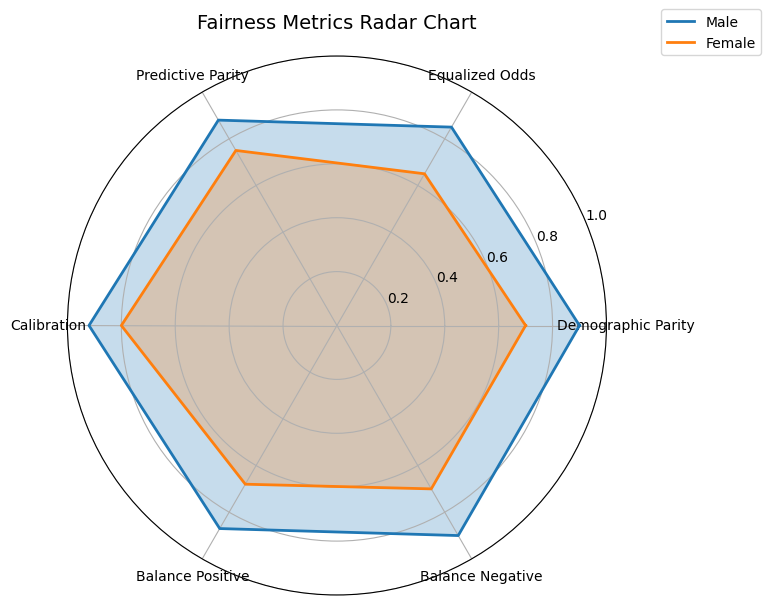

In [ ]:
# Example usage:
example_metrics = {
    "Male": {
        "Demographic Parity": 0.9,
        "Equalized Odds": 0.85,
        "Predictive Parity": 0.88,
        "Calibration": 0.92,
        "Balance Positive": 0.87,
        "Balance Negative": 0.9
    },
    "Female": {
        "Demographic Parity": 0.7,
        "Equalized Odds": 0.65,
        "Predictive Parity": 0.75,
        "Calibration": 0.8,
        "Balance Positive": 0.68,
        "Balance Negative": 0.7
    }
}

plot_fairness_radar(example_metrics)

* **Conditional Statistical Parity Heatmap**

In [26]:
results = conditional_statistical_parity(y_pred=df_encoded["prediction"], protected_attributes=df_encoded["education"], legitimate_attributes=df_encoded["sex"])
results

[{'stratum': '0',
  'group_selection_rates': {'0': 0.09859154929577464,
   '1': 0.1111111111111111,
   '2': 0.15789473684210525,
   '3': 0.0,
   '4': 0.0,
   '5': 0.05825242718446602,
   '6': 0.14285714285714285,
   '7': 0.05,
   '8': 0.0,
   '9': 0.0,
   '10': 0.14285714285714285,
   '11': 0.0,
   '12': 0.1111111111111111,
   '13': 0.0,
   '14': 0.0},
  'disparity': 0.15789473684210525},
 {'stratum': '1',
  'group_selection_rates': {'0': 0.1346153846153846,
   '1': 0.1111111111111111,
   '2': 0.1,
   '3': 0.3333333333333333,
   '4': 0.0,
   '5': 0.08928571428571429,
   '6': 0.25,
   '7': 0.125,
   '9': 0.0,
   '10': 0.0,
   '11': 1.0,
   '12': 0.0,
   '13': 0.0,
   '14': 0.5},
  'disparity': 1.0}]

In [ ]:
def plot_conditional_statistical_parity(results):
    """
    Plots a heatmap of conditional statistical parity.
    
    Args:
        results (list of dict): Each dict has 'stratum', 'group_selection_rates', 'disparity'
    """
    # Convert results into DataFrame for heatmap
    data = {}
    for res in results:
        stratum = res['stratum']
        for group, rate in res['group_selection_rates'].items():
            if group not in data:
                data[group] = {}
            data[group][stratum] = rate
    
    df = pd.DataFrame(data).T  # groups as rows, strata as columns
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(df, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Selection Rate'})
    plt.xlabel("Stratum")
    plt.ylabel("Group")
    plt.title("Conditional Statistical Parity Heatmap")
    plt.show()

def plot_conditional_statistical_parity(results):
    # Convert results into DataFrame for heatmap
    data = {}
    for res in results:
        stratum = res['stratum']
        for group, rate in res['group_selection_rates'].items():
            if group not in data:
                data[group] = {}
            data[group][stratum] = rate

    df = pd.DataFrame(data).T  # groups as rows, strata as columns

    plt.figure(figsize=(12, 6))
    sns.heatmap(df, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Selection Rate'})
    plt.xlabel("Stratum")
    plt.ylabel("Group")
    plt.title("Conditional Statistical Parity Heatmap")
    plt.show()


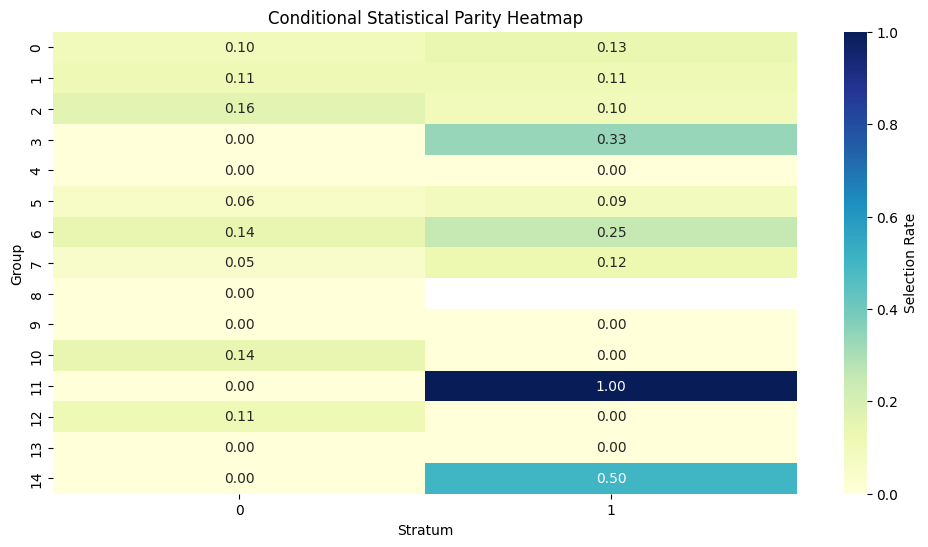

In [28]:
plot_conditional_statistical_parity(results)

* **Cumulative Parity Loss**

In [13]:
print("""# Example fairness metrics for two groups ("Male", "Female")
data = {
    "Male": {
        "TPR": 0.10,
        "PPV": 0.15,
        "FPR": 0.05,
        "ACC": 0.20,
        "SPR": 0.12
    },
    "Female": {
        "TPR": 0.08,
        "PPV": 0.18,
        "FPR": 0.07,
        "ACC": 0.22,
        "SPR": 0.10
    }
}

groups = list(data.keys())
metrics = list(next(iter(data.values())).keys())

# Convert dictionary to arrays
values = np.array([[data[g][m] for m in metrics] for g in groups])

# Plotting
fig, ax = plt.subplots(figsize=(8, 5))

# Horizontal stacked bar chart
left = np.zeros(len(groups))
for i, metric in enumerate(metrics):
    ax.barh(groups, values[:, i], left=left, label=metric)
    left += values[:, i]

# Labels and style
ax.set_xlabel("Cumulative Parity Loss")
ax.set_ylabel("Protected Subgroups")
ax.set_title("Stacked Parity Loss by Subgroup")
ax.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()""")

# Example fairness metrics for two groups ("Male", "Female")
data = {
    "Male": {
        "TPR": 0.10,
        "PPV": 0.15,
        "FPR": 0.05,
        "ACC": 0.20,
        "SPR": 0.12
    },
    "Female": {
        "TPR": 0.08,
        "PPV": 0.18,
        "FPR": 0.07,
        "ACC": 0.22,
        "SPR": 0.10
    }
}

groups = list(data.keys())
metrics = list(next(iter(data.values())).keys())

# Convert dictionary to arrays
values = np.array([[data[g][m] for m in metrics] for g in groups])

# Plotting
fig, ax = plt.subplots(figsize=(8, 5))

# Horizontal stacked bar chart
left = np.zeros(len(groups))
for i, metric in enumerate(metrics):
    ax.barh(groups, values[:, i], left=left, label=metric)
    left += values[:, i]

# Labels and style
ax.set_xlabel("Cumulative Parity Loss")
ax.set_ylabel("Protected Subgroups")
ax.set_title("Stacked Parity Loss by Subgroup")
ax.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()
